In [97]:
import warnings
import sqlite3
import pandas as pd

import conf


warnings.filterwarnings('ignore')

In [98]:
connection = sqlite3.connect(conf.DB_NAME)
cursor = connection.cursor()
df = pd.read_sql(sql="SELECT * FROM presentation", con=connection)

In [99]:
df.head(3)

,user,currency,total_sales,purchase_number,favorite_segment,M0_cohort,M1_retention,lifespan_days
0,65326324392533,eur,250.0,1,meal,2023-05,0,0
1,168982159910603,eur,650.0,1,snack,2023-08,0,0
2,219034330643057,eur,2020.0,3,meal,2022-11,1,359


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123210 entries, 0 to 123209
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user              123210 non-null  object 
 1   currency          123210 non-null  object 
 2   total_sales       123210 non-null  float64
 3   purchase_number   123210 non-null  int64  
 4   favorite_segment  123210 non-null  object 
 5   M0_cohort         123210 non-null  object 
 6   M1_retention      123210 non-null  int64  
 7   lifespan_days     123210 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 7.5+ MB


In [101]:
df.purchase_number.value_counts(normalize=True, bins=10)

(0.738, 27.1]     0.998052
(27.1, 53.2]      0.001753
(53.2, 79.3]      0.000179
(79.3, 105.4]     0.000008
(235.9, 262.0]    0.000008
(105.4, 131.5]    0.000000
(131.5, 157.6]    0.000000
(157.6, 183.7]    0.000000
(183.7, 209.8]    0.000000
(209.8, 235.9]    0.000000
Name: proportion, dtype: float64

In [102]:
# There is a wide range between number or purchases per user,
# let's explore the quantiles of the column
df.purchase_number.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

0.25     1.0
0.50     1.0
0.75     3.0
0.90     5.0
0.95     7.0
0.99    15.0
Name: purchase_number, dtype: float64

In [103]:
# 99% of users make less than 15 orders during entire lifespan,
# let's explore those 1%

total_purchases = df.purchase_number.sum()
top_users_purchases_num = df[df.purchase_number >= 15].purchase_number.sum()
purch_made_by_tops = 100 * top_users_purchases_num / total_purchases
top_users_num = len(df[df.purchase_number >= 15])

print(f"Only 1% of users ({top_users_num} individuals) is making {purch_made_by_tops: .1f} % of all purchases")

Only 1% of users (1441 individuals) is making  10.6 % of all purchases


In [104]:
# When it comes to understand how valuable new customer could be, those top individuals 
# would be considered as a positive "error" and excluded from statistic

# Further statistics would be calculated on the quantile 99 being less optimistic (and little decrease expectations)

# P.S.: top users could be analyzed separately, because of their huge value for business

df_q99 = df[df.purchase_number < 15]

In [105]:
# Let's check the average purchase number

avg_purchase_num = df_q99.purchase_number.mean()
made_one_order = 100 * len(df_q99[df_q99.purchase_number == 1])/ len(df_q99)
avg_if_several_orders = df_q99[df_q99.purchase_number > 1].purchase_number.mean()

print(f"In average, the user is making {avg_purchase_num: .1f} orders")
print(f"{made_one_order: .1f}% of users made only 1 order")
print(f"From those, who made more than 1 order, the average number of orders is{avg_if_several_orders: .1f}")

In average, the user is making  2.2 orders
 54.6% of users made only 1 order
From those, who made more than 1 order, the average number of orders is 3.6


In [106]:
# Average order value analysis

df_q99['avg_order'] = df_q99.total_sales / df_q99.purchase_number
avg_val = df_q99['avg_order'].mean()
avg_val_one_order = df_q99[df_q99.purchase_number == 1].avg_order.mean()
avg_val_some_orders = df_q99[df_q99.purchase_number > 1].avg_order.mean()

print(f"The average value of the order is{avg_val: .1f} monetary units")
print(f"For those, who made only 1 order the average value is{avg_val_one_order: .1f} monetary units")
print(f"For others, the average value is{avg_val_some_orders: .1f} monetary units")


The average value of the order is 841.3 monetary units
For those, who made only 1 order the average value is 890.3 monetary units
For others, the average value is 782.6 monetary units


<Axes: >

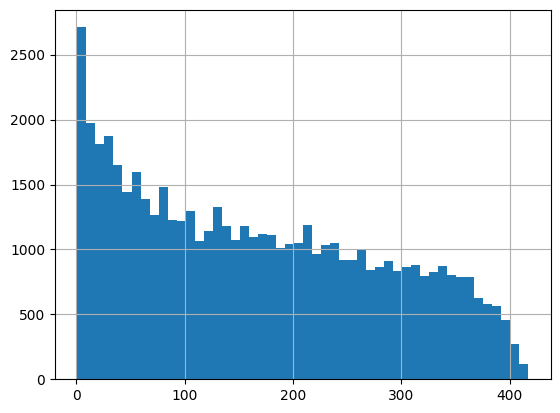

In [107]:
# Users' lifespan analysis

# We mentioned earlier, that 54.6% of users made only 1 order which means their lifespan is zero days.
# For this reason it's interesting to look at the distribution of those who has a lifespan

df_q99[df_q99.lifespan_days != 0].lifespan_days.hist(bins=50)

# The area under the curve is pretty full, the curve itself is really smooth.
# From the first view it seems like those, who made the second order is using the service in future 

In [108]:
# There is some limitations from the data (info within around a year), but we can make some statistics

avg_lifespan_many_orders = df_q99[df_q99.lifespan_days != 0].lifespan_days.mean()

print(f"{100-made_one_order: .1f}% of users made more than 1 order and their average lifespan is{avg_lifespan_many_orders: .1f} days")
print(f"During that time (in average) they are making{avg_if_several_orders: .1f} orders each size of{avg_val_some_orders: .1f} monetary units")

 45.4% of users made more than 1 order and their average lifespan is 166.4 days
During that time (in average) they are making 3.6 orders each size of 782.6 monetary units
